In [1]:
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

seed = 42

In [2]:
train = pd.read_parquet("train_temporal_regression.parquet.gz")
test = pd.read_parquet("test_temporal_regression.parquet.gz")

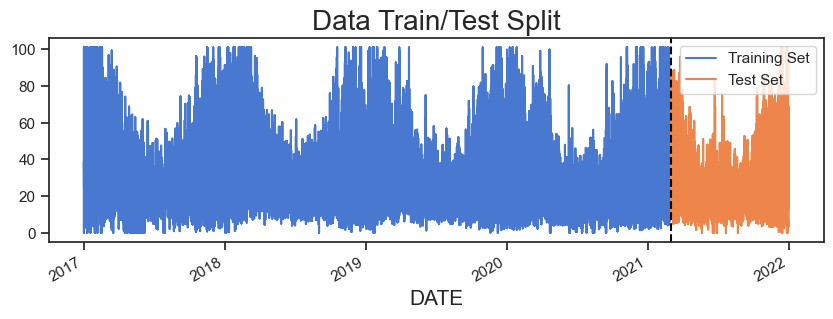

In [3]:
#Visualizing how the data is split
cut_off_date="2021-03-01"

fig, ax = plt.subplots(figsize=(10, 3))

train.plot(y='CAQI_idx', ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(y='CAQI_idx', ax=ax, label='Test Set')

ax.axvline(cut_off_date, color='black', ls='--')

ax.legend(['Training Set', 'Test Set'])
plt.show();

In [4]:
#Splitting to X and y variables

X_train = train.drop('CAQI_idx', axis=1)
y_train = train['CAQI_idx']

X_test = test.drop('CAQI_idx', axis=1)
y_test = test['CAQI_idx']

In [5]:
#Deserializing pickled encoder
with open("encoders.pkl", "rb") as r:
    encoders = pickle.load(r)

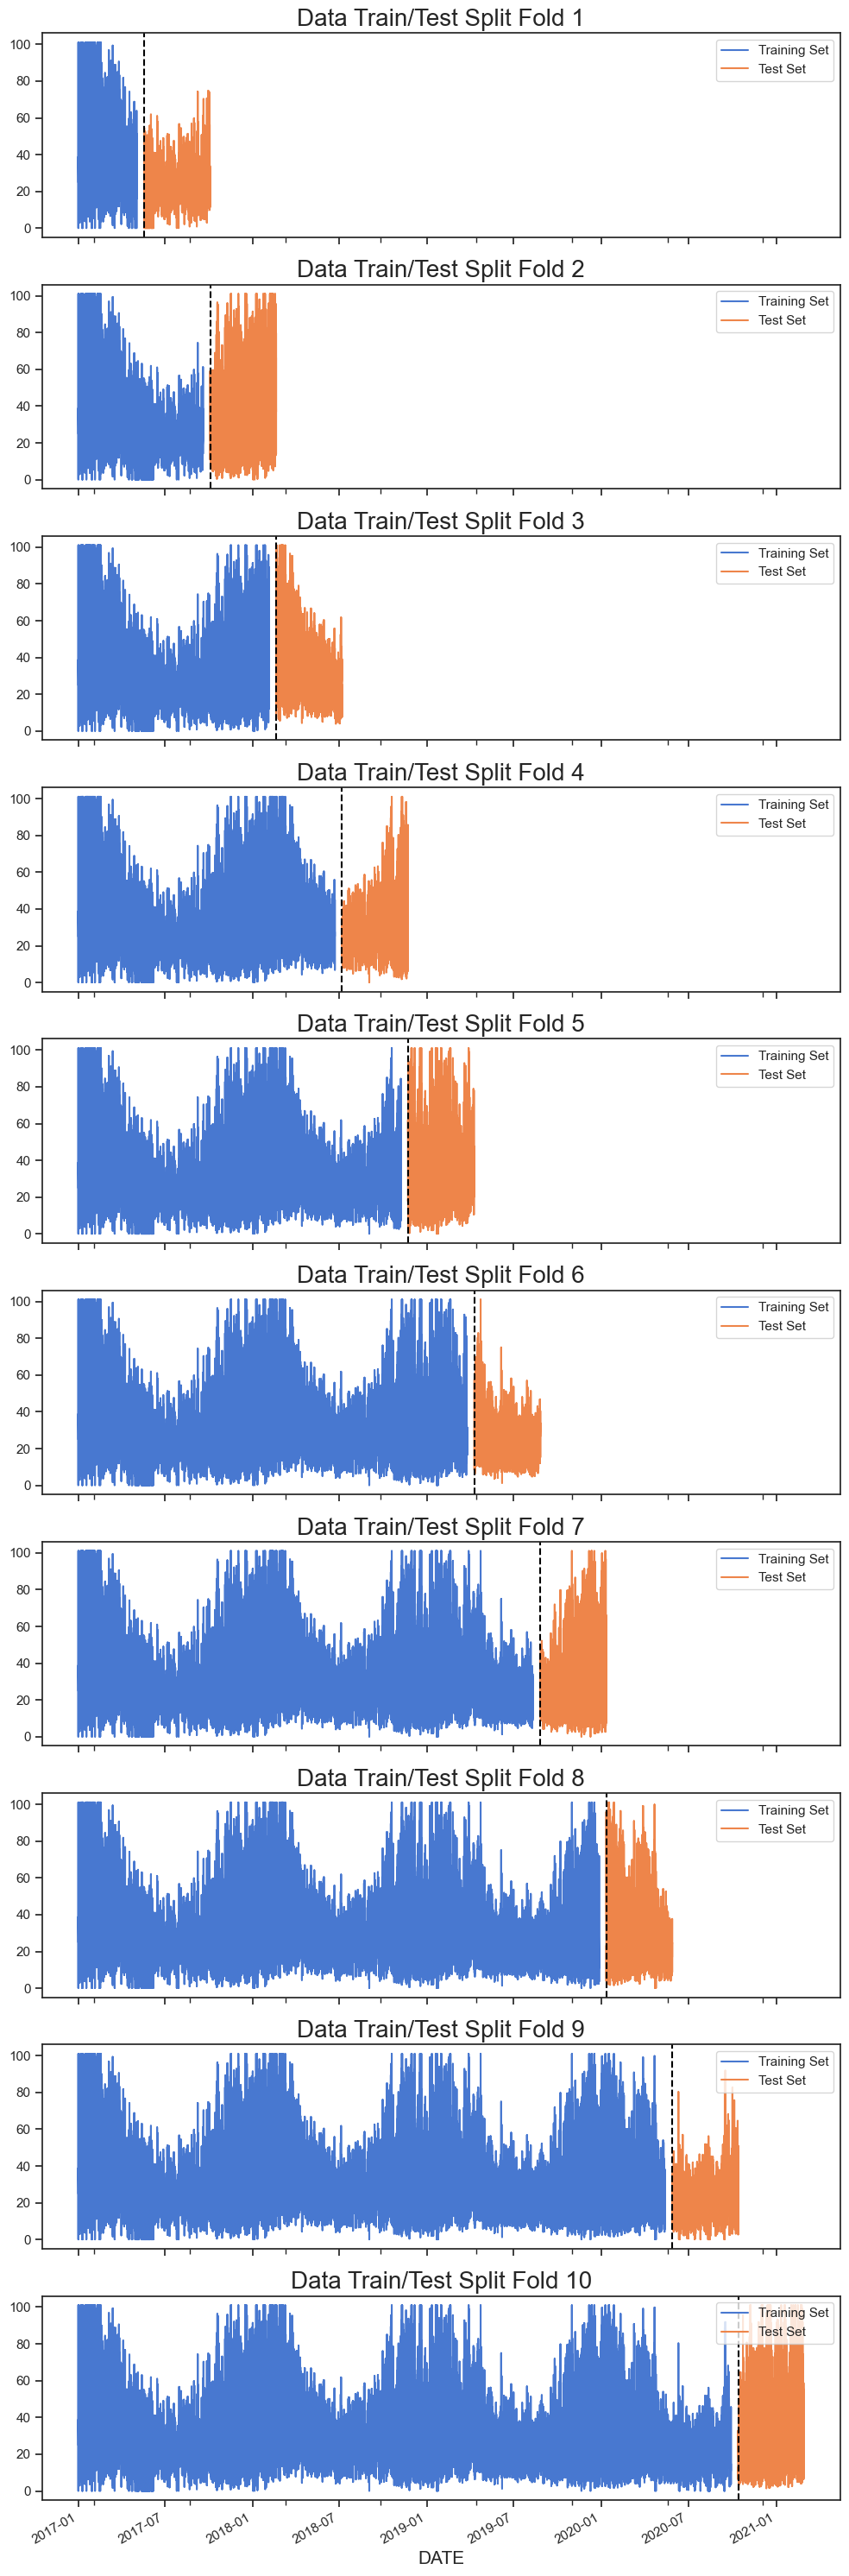

In [6]:
#Visualizing how the cross validation will be done
n_split = 10

max_train_size=None
test_size=None

# max_train_size=198*638
# test_size=198*90

tss = TimeSeriesSplit(
    n_splits=n_split, 
    max_train_size=max_train_size, 
    test_size=test_size, 
    gap=198*15
)

fig, axs = plt.subplots(n_split, 1, figsize=(10, n_split*3), sharex=True, tight_layout=True)

fold = 0
for train_idx, val_idx in tss.split(train):
    train_cv = train.iloc[train_idx]
    test_cv = train.iloc[val_idx]
    
    train_cv.plot(y='CAQI_idx', ax=axs[fold], label='Training Set',
                  title=f'Data Train/Test Split Fold {fold + 1}')
    
    test_cv.plot(y='CAQI_idx', ax=axs[fold], label='Test Set')
    
    axs[fold].axvline(test_cv.index.min(), color='black', ls='--')
    
    fold += 1

In [7]:
def cross_validate_and_test(cv, pipeline, X_train, y_train, X_test, y_test):
    
    rmse_values = []

    count = 1
    # Loop through the folds
    print("Cross Validating.....")
    print()

    for train_index, test_index in cv.split(X_train, y_train):

        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # Fit the model on the train data
        pipeline.fit(X_train_cv, y_train_cv)

        # Predict on the test data
        y_pred = pipeline.predict(X_test_cv)

        # Calculate the mean squared error
        rmse = mean_squared_error(y_test_cv, y_pred, squared=False)

        print(f"cv #{count}: RMSE = {rmse:.3f}")

        rmse_values.append(rmse)
        count += 1

    # Print the average MSE over all folds
    print()
    print(f"Average Train RMSE: {np.mean(rmse_values):.3f} ± {np.std(rmse_values):.2f}")


    #Predicting on Test set
    predictions = pipeline.predict(X_test)
    test_rmse = mean_squared_error(y_test, predictions, squared=False)

    print(f"Test RMSE Score: {test_rmse:.3f}")
    print()
    
    plot_cv_results(pipeline=pipeline)
    
    return predictions
    
    
def plot_cv_results(pipeline):
    
    feat_scores=pipeline.steps[-1][-1].feature_importances_
    feat_names=pipeline.steps[-1][-1].feature_names_in_

    #Creating a dataframe for feature importance
    feat_imp_df = \
    pd.DataFrame({
    #     'features' : encoders.fit_transform(X_train).columns,
        'features' : feat_names,
        'importance' : np.abs(np.round(feat_scores, 3))
    }).set_index('features').sort_values('importance')
    
    
    #Print Features with Low Importance
    print("Features with Low Importance:")
    print(np.sort(feat_imp_df.query("importance<=0.001").index))
    
    #Plot
    ax = feat_imp_df.plot(kind='barh', edgecolor='k', figsize=(3, 20))
    ax.bar_label(ax.containers[0], fontsize=13, padding=3);
    ax.legend().remove()
    ax.set_title("Feature Importance")
    
    plt.show();

In [8]:
def compare_actual_predicted_ts(predictions, X_test):
    
    test_df = pd.concat([X_test[['powiat_voivod', 'voivodship']], y_test], axis=1)
    test_df['predictions'] = predictions
    test_df['error'] = test_df['CAQI_idx'] - test_df['predictions']
    
    #Plot Actual Vs Predicted
    test_df.groupby(test_df.index)[['CAQI_idx', 'predictions']].mean().\
    plot(title='Actual vs Predicted CAQI', figsize=(10, 4));
    
    actual_predicted_scatterplot(test_df=test_df)
    plot_high_mean_CAQI_powiat(test_df=test_df)
    plot_low_mean_CAQI_powiat(test_df=test_df)
    
    
def actual_predicted_scatterplot(test_df):
    r2 = r2_score(test_df['CAQI_idx'], test_df['predictions'])

    fig, ax = plt.subplots(figsize=(8, 6))

    test_df.plot(x='predictions', y='CAQI_idx', kind='scatter', edgecolor='k', c='b', 
                 alpha=0.7, ax=ax, label=f"$r^2$ - {r2:.3f}");

    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='r', ls='--')  
    ax.legend(fontsize=15)
    ax.set_ylabel("Actual CAQI")
    ax.set_xlabel("Predicted CAQI");
    
    plt.show()
    
def plot_high_mean_CAQI_powiat(test_df):
    
    #Powiat with highest mean CAQI
    ax = test_df.query("powiat_voivod=='powiat warszawa, mazowieckie'").\
        plot(y=["CAQI_idx", "predictions"], figsize=(10, 3))

    ax.set_title("powiat warszawa, mazowieckie");
    
    plt.show()

def plot_low_mean_CAQI_powiat(test_df):
    #Powiat with lowest mean CAQI
    ax = test_df.query("powiat_voivod=='powiat warszawski zachodni, mazowieckie'").\
        plot(y=["CAQI_idx", "predictions"], figsize=(10, 3))

    ax.set_title("powiat warszawski zachodni, mazowieckie");
    
    plt.show()

In [9]:
# XGBoost
xgb=XGBRegressor(
    n_estimators=450,
    max_depth=5,
    learning_rate=0.018,
    gamma=4.5,
    reg_alpha=7.85,
    reg_lambda=3.434,
    subsample=0.743,
    colsample_bytree=0.646,
    min_child_weight=3,
    objective='reg:squarederror',
    eval_metric='rmse',
    booster='gbtree',
    n_jobs=-1,
)

#Putting whole pipeline together
pipeline = make_pipeline(
    (encoders), #Encoders
    (xgb) #XGBoost
)

print("Pipeline Created!")

Pipeline Created!


### Baseline Model Test RMSE Score - 8.024

Cross Validating.....

cv #1: RMSE = 6.244
cv #2: RMSE = 12.329
cv #3: RMSE = 8.771
cv #4: RMSE = 8.043
cv #5: RMSE = 11.955
cv #6: RMSE = 5.297
cv #7: RMSE = 9.537
cv #8: RMSE = 8.708
cv #9: RMSE = 5.240
cv #10: RMSE = 10.949

Average Train RMSE: 8.707 ± 2.44
Test RMSE Score: 7.718

Features with Low Importance:
['air pollution reduction systems - waste gas flow - efficiency high'
 'production of electricity - from renewable energy sources'
 'production of electricity - thermal power plants, total']


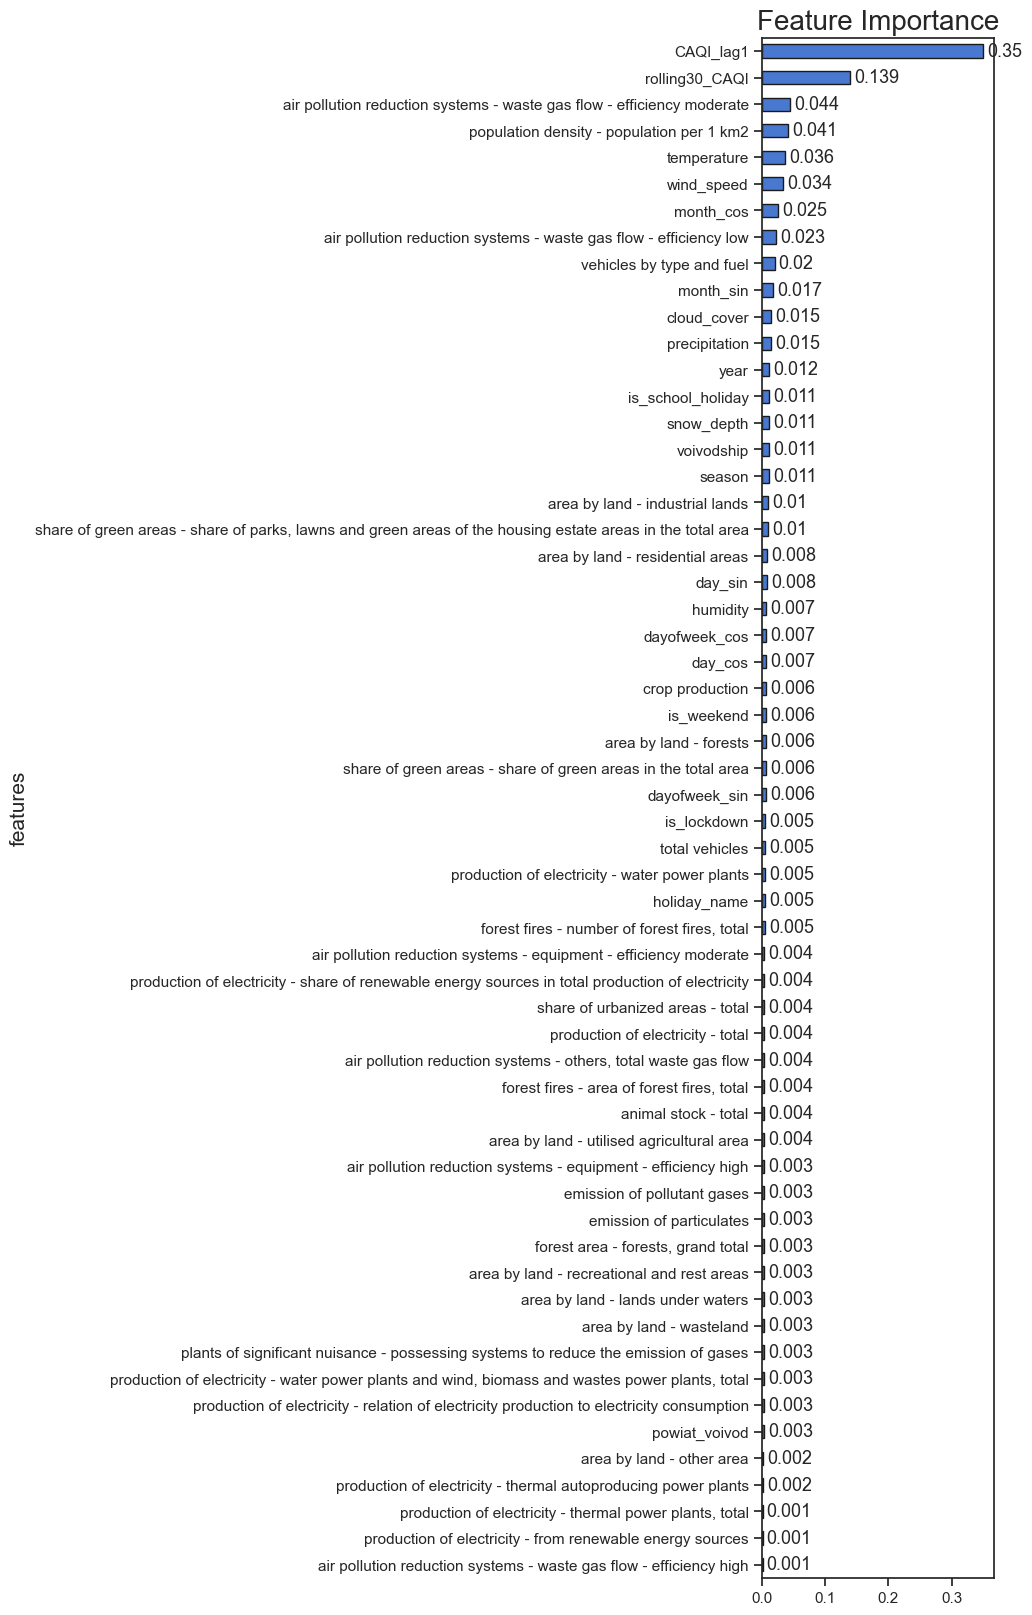

Wall time: 12min 53s


In [10]:
%%time
#Training the pipeline using Cross validation
predictions = cross_validate_and_test(cv=tss, 
                                      pipeline=pipeline, 
                                      X_train=X_train, 
                                      y_train=y_train, 
                                      X_test=X_test, 
                                      y_test=y_test)

### Tuned Model Test RMSE Score - 7.718

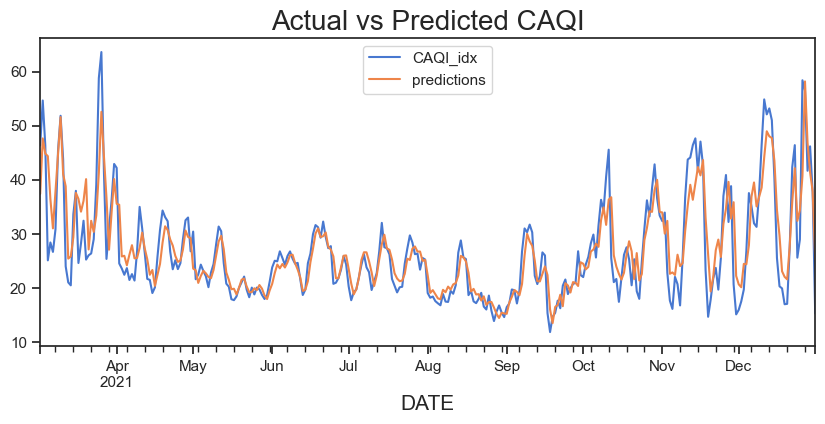

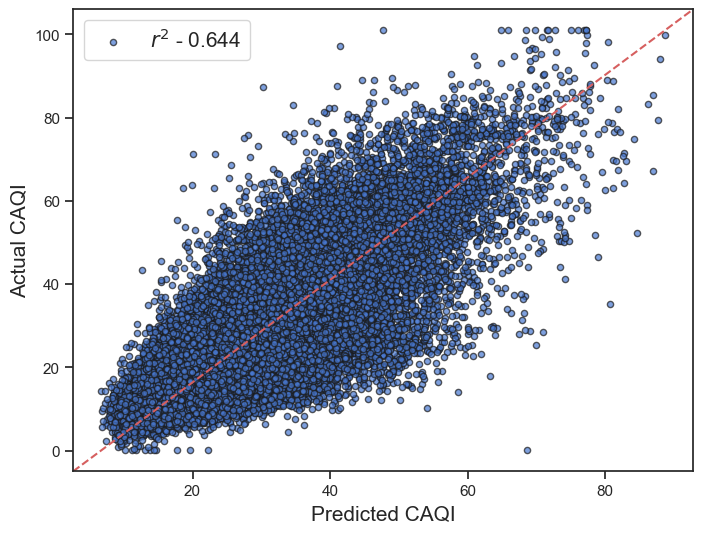

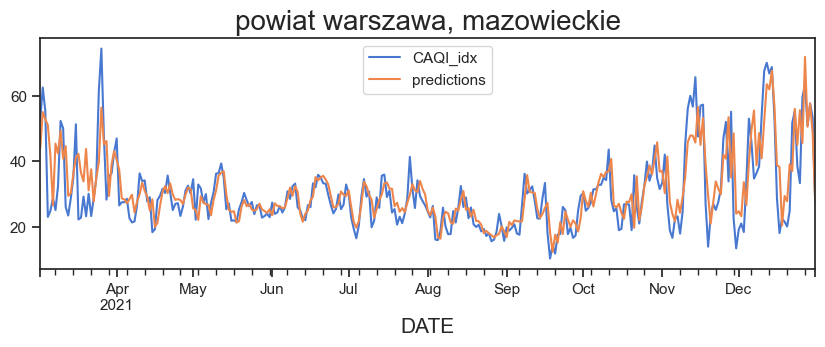

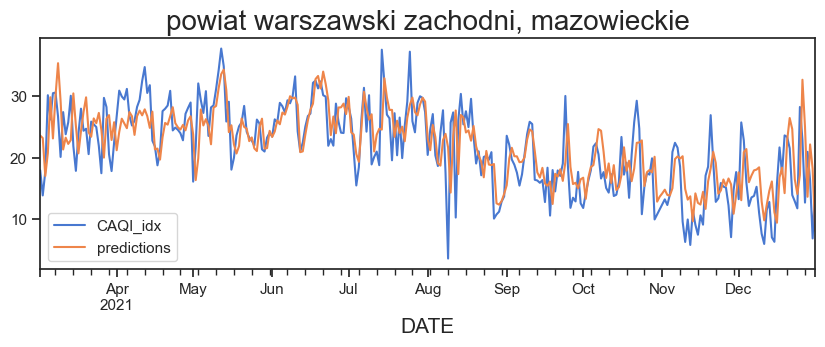

In [11]:
compare_actual_predicted_ts(predictions=predictions, X_test=X_test)

# Training the tuned model on the whole dataset and then save model

In [17]:
#Merging train and test set
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

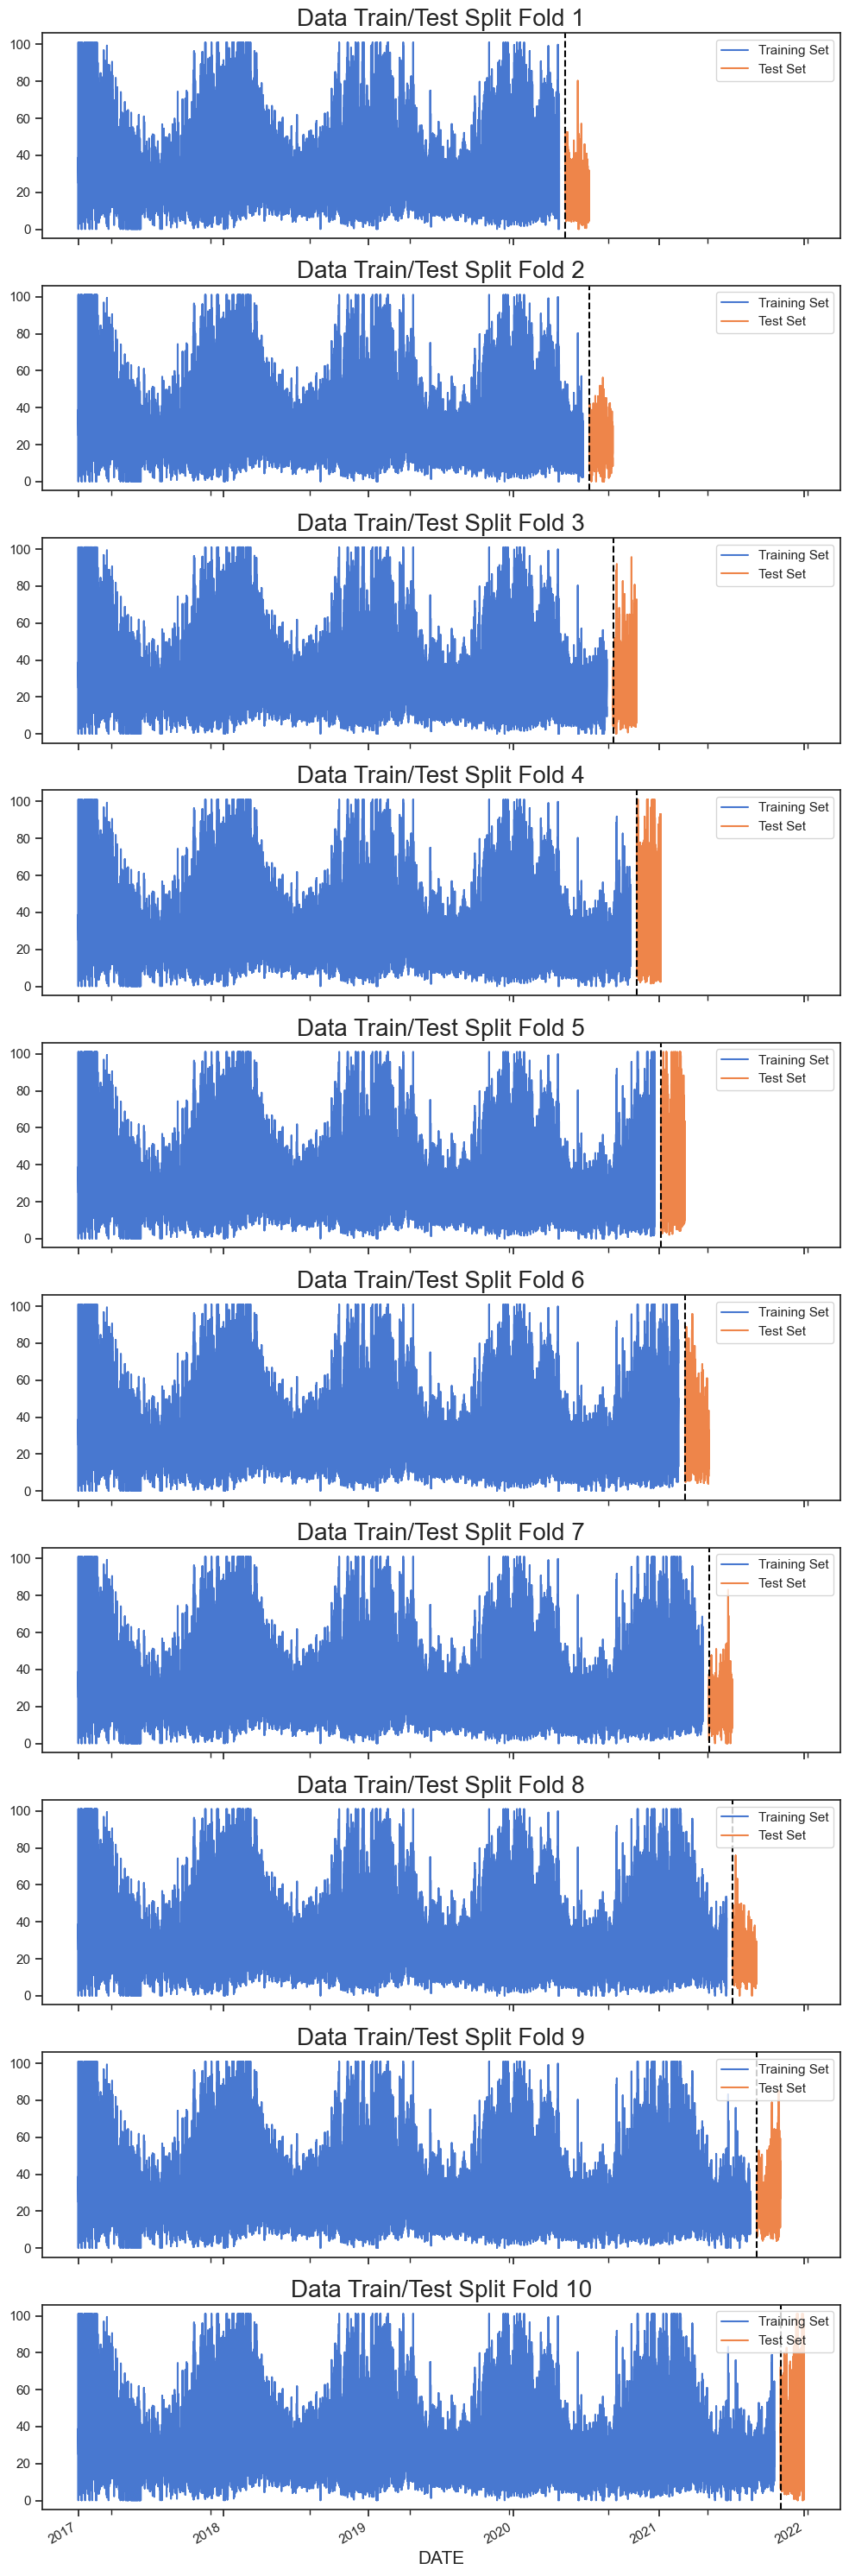

In [32]:
#Visualizing how the whole dataset will be splitted during cross validation
#Visualizing how the cross validation will be done
n_split = 10

max_train_size=None
test_size=198*60

tss = TimeSeriesSplit(
    n_splits=n_split, 
    max_train_size=max_train_size, 
    test_size=test_size, 
    gap=198*15
)

fig, axs = plt.subplots(n_split, 1, figsize=(10, n_split*3), sharex=True, tight_layout=True)

fold = 0
for train_idx, val_idx in tss.split(pd.concat([X, y], axis=1)):
    train_cv = pd.concat([X, y], axis=1).iloc[train_idx]
    test_cv = pd.concat([X, y], axis=1).iloc[val_idx]
    
    train_cv.plot(y='CAQI_idx', ax=axs[fold], label='Training Set',
                  title=f'Data Train/Test Split Fold {fold + 1}')
    
    test_cv.plot(y='CAQI_idx', ax=axs[fold], label='Test Set')
    
    axs[fold].axvline(test_cv.index.min(), color='black', ls='--')
    
    fold += 1

In [34]:
# XGBoost
xgb=XGBRegressor(
    n_estimators=450,
    max_depth=5,
    learning_rate=0.018,
    gamma=4.5,
    reg_alpha=7.85,
    reg_lambda=3.434,
    subsample=0.743,
    colsample_bytree=0.646,
    min_child_weight=3,
    objective='reg:squarederror',
    eval_metric='rmse',
    booster='gbtree',
    n_jobs=-1,
)

#Putting whole pipeline together
final_pipeline = make_pipeline(
    (encoders), #Encoders
    (xgb) #XGBoost
)

print("Pipeline Created!")

Pipeline Created!


In [35]:
%%time
rmse_values = []

count = 1
# Loop through the folds
print("Cross Validating.....")
print()

for train_index, test_index in tss.split(X, y):

    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the train data
    final_pipeline.fit(X_train_cv, y_train_cv)

    # Predict on the test data
    y_pred = final_pipeline.predict(X_test_cv)

    # Calculate the mean squared error
    rmse = mean_squared_error(y_test_cv, y_pred, squared=False)

    print(f"cv #{count}: RMSE = {rmse:.3f}")

    rmse_values.append(rmse)
    count += 1

# Print the average MSE over all folds
print()
print(f"Average Train RMSE: {np.mean(rmse_values):.3f} ± {np.std(rmse_values):.2f}")
print()

Cross Validating.....

cv #1: RMSE = 4.077
cv #2: RMSE = 3.833
cv #3: RMSE = 7.894
cv #4: RMSE = 10.152
cv #5: RMSE = 12.892
cv #6: RMSE = 8.983
cv #7: RMSE = 3.988
cv #8: RMSE = 4.097
cv #9: RMSE = 6.915
cv #10: RMSE = 11.318

Average Train RMSE: 7.415 ± 3.20

Wall time: 26min 3s


In [38]:
#Serializing the final model
with open("final_model.pkl", "wb") as w:
    pickle.dump(final_pipeline, w)